In [1]:
%load_ext line_profiler

In [2]:
from datetime import datetime as dt, timedelta
start_date = dt(2016, 1, 1, 0, 0, 0) #best results when train from 4/2016 and onward # maybe do small window retraining
end_date = dt(2016, 11, 23, 0, 0, 0)
price_window = 200
tweet_window = 200
min_tweets = 1
cutoff = .25
retweets_min = 1

import pandas as pd
df = pd.read_csv('data_new.csv', parse_dates=['Date','Date_Time'])
# print(df.iloc[-1])
start_index = df[df['Date'] == start_date].iloc[[0]].index.values[0]
df = df[start_index:]
df = df.set_index(['Date_Time'])
# print(df)

# set up db
from pymongo import MongoClient

db = MongoClient("mongodb://104.236.1.250:27017")['bitcoin_scraped']
db.authenticate('meir', 'PreemPalver', source='bitcoin_scraped')
collection = db['scraped1agg']
count_min = 0
retweet_min = 0
tweets = list(collection.find({"_id": {"$lt": end_date}, "count": {"$gte": count_min},"retweets_total": {"$gte": retweet_min}}).sort([("_id", 1)]))
t2 = len(list(collection.find({"count": {"$gte": count_min},"retweets_total": {"$gte": retweet_min}}, { '_id':1}).sort([("_id", 1)])))
t3 = len(list(collection.find({"count": {"$gte": count_min}}, { '_id':1}).sort([("_id", 1)])))
print(len(tweets), t2, t3)

42655 49781 49781


In [3]:
import numpy as np
from collections import Counter

def getNearest(t, df):
    i = df.index.searchsorted(t)
    if i == 471378: print(t)
    return  df.iat[i,2] #df.ix[df.index[i]]['Price']

def getDelta(df, date, delta_minutes, cutoff):
    df2 = df[:-(3*delta_minutes)]
    date = np.datetime64(date)
    delta_minutes = np.timedelta64(delta_minutes,'m')
    p2 = getNearest(date + delta_minutes, df2)
    p1 = getNearest(date, df2)
    m = p2 - p1
    if m > cutoff: return 2
    if m < -cutoff: return 0
    return 1 

In [4]:
from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

def studyWords(tweets):
    dwords = {}
    for tweet in tweets:
        texts = tweet['text']
        for text in texts:
            blob = TextBlob(text.lower())
            words = [x[0] for x in blob.tags]
            for word in words:
                if word not in dwords: dwords[word] = 1
                else: dwords[word] = dwords[word] + 1
    print(len(dwords))
    dwords = {k: dwords[k] for k in dwords if len(k) > 1 and k not in ENGLISH_STOP_WORDS and re.match("^[a-z]*$", k)}
    dwords = sorted(dwords.items(), key=lambda x: -1 * x[1])
    dwords = ([x[0] for x in dwords[:200]])
    return dwords
dwords = studyWords(tweets)

61550


In [5]:
counts_up = Counter()
counts_down = Counter()
for tweet in tweets:
    texts = tweet['text']
    date = tweet['_id']
    
    delta = getDelta(df, np.datetime64(date), 200, 0)
    for text in texts:
        words = [w.lstrip('#') for w in text.lower().split(' ')]
        words = [w for w in words if w in dwords]
        if delta > 1: counts_up.update(words)
        if delta < 1: counts_down.update(words)
print(counts_up, counts_down)

Counter({'bitcoin': 30909, 'price': 8290, 'btc': 8217, 'blockchain': 6101, 'litecoin': 4788, 'wallet': 3690, 'currency': 3000, 'current': 2588, 'mt': 2089, 'mining': 2061, 'gox': 2056, 'new': 1927, 'altcoin': 1783, 'usd': 1760, 'news': 1557, 'digital': 1307, 'ltc': 1252, 'bank': 1140, 'cryptocurrency': 1078, 'ethereum': 979, 'satoshi': 915, 'market': 896, 'miner': 847, 'money': 832, 'free': 828, 'crypto': 820, 'latest': 817, 'economy': 809, 'direct': 804, 'value': 682, 'aktueller': 673, 'kurs': 672, 'exchange': 630, 'prices': 611, 'trading': 610, 'technology': 555, 'just': 553, 'dogecoin': 552, 'like': 550, 'fintech': 535, 'card': 487, 'today': 482, 'retweet': 470, 'time': 462, 'portal': 456, 'start': 454, 'landbitcoin': 446, 'index': 445, 'bitcoins': 430, 'power': 429, 'past': 419, 'marinecoin': 414, 'tech': 410, 'chain': 405, 'buy': 387, 'use': 381, 'eth': 376, 'think': 374, 'coindesk': 368, 'real': 366, 'using': 366, 'riser': 357, 'best': 355, 'earn': 354, 'newsbtc': 350, 'average':

In [43]:
%matplotlib inline
print(len(counts_up))
import matplotlib.pyplot as plt
D = counts_up - counts_down
print(len(D))
D2 = counts_up + counts_down
D2 = {k:D2[k] for k in D2.keys()}
D3 = {k: D[k]/D2[k] for k in D.keys()}
D = {k: D[k]/D2[k] for k in D.keys() if D[k]/D2[k] >= .225}
print(D.keys())
# plt.show()




200
195
dict_keys(['smart', 'week', 'join', 'antminer', 'real', 'value', 'currencies', 'past', 'cloud', 'win', 'cryptocoinsnews', 'app', 'block', 'chain', 'prices'])


15
0 value 1105 0.2343891402714932
1 prices 981 0.24566768603465852
2 past 672 0.24702380952380953
3 chain 653 0.24042879019908117
4 real 595 0.23025210084033612
5 cryptocoinsnews 519 0.2524084778420039
6 smart 518 0.23938223938223938
7 cloud 507 0.27416173570019725
8 win 491 0.23014256619144602
9 currencies 368 0.22826086956521738
10 join 352 0.24431818181818182
11 block 344 0.27325581395348836
12 antminer 336 0.2619047619047619
13 week 311 0.2733118971061093
14 app 274 0.25547445255474455
0.14573255490686685 0.08571428571428572


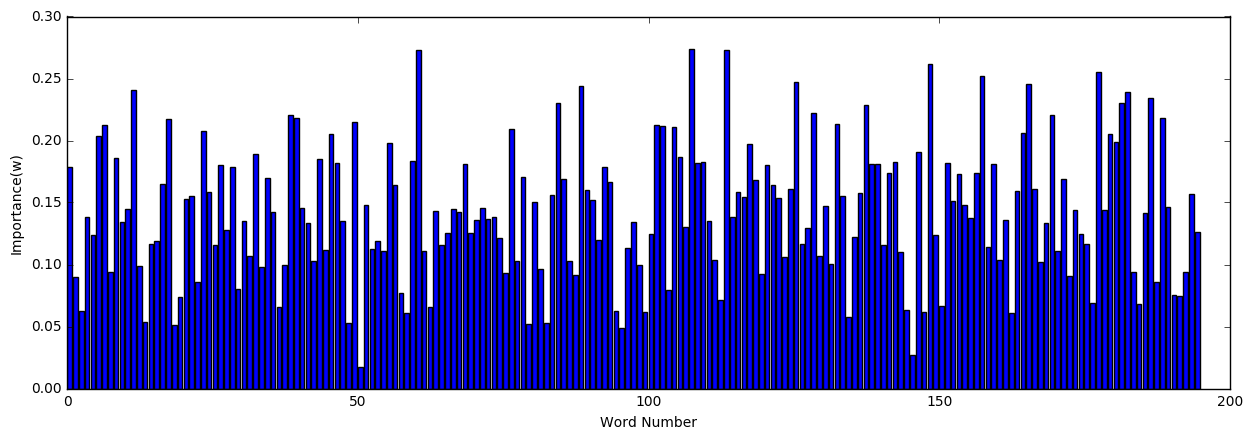

In [52]:
plt.rcParams["figure.figsize"] = [15, 4.8]
plt.bar(range(len(D3)), D3.values())
# plt.bar(range(len(D2)), D2.values(), align='center', color='g')

print(len(D.keys()))
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
for i, (k, v) in enumerate(sorted({k:D2[k] for k in D.keys()}.items(), key=lambda x: -x[1])):
    print(i, k, v, D[k])
print(D3['bitcoin'], D3['euro'])

plt.ylabel('Importance(w)')
plt.xlabel('Word Number')
# plt.xticks(range(len(D3)), range(len(D3)))
plt.rcParams["figure.figsize"] = [6.4, 4.8]

In [8]:
percents = []

def change_stats(df, price_window):
    df2 = df[:-(5*price_window)]
    number_samples = int(len(df2)/20)
    dlist = np.random.choice(df2.index.values, number_samples)
    dlist = [getDelta(df, d, price_window, 0) for d in dlist]
    dlist_count = Counter(dlist)
    nonTweet_percentPos = dlist_count[2]/(number_samples - dlist_count[1])
    
    return nonTweet_percentPos

def get_price_stats():
    price_windows = [50, 100, 150, 170, 200, 250, 300, 350, 400]
    for price_window in price_windows:
        print(price_window)
        percents.append(change_stats(df, price_window))
    return percents, price_windows
    
print(change_stats(df, 200))
percents, price_windows = get_price_stats()
print(percents)

0.5289845840234425
50
100
150
170
200
250
300
350
400
[0.5184871099050203, 0.5199609689873149, 0.5145161290322581, 0.5192748577736266, 0.5174756869240243, 0.5326959847036329, 0.5290566679420142, 0.521694742215416, 0.5304081372090054]


9
9


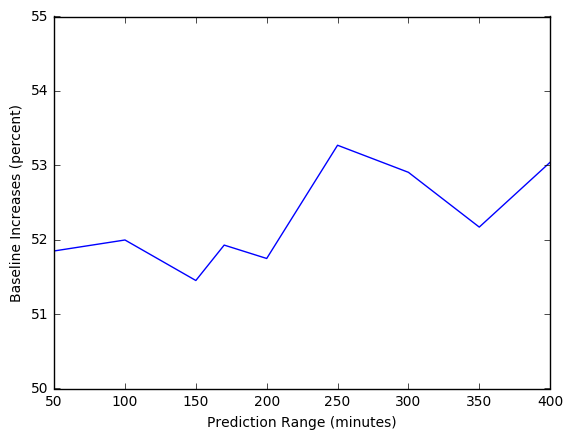

In [9]:
import matplotlib.pyplot as plt
p = [100 * x for x in percents]
print(len(p))
print(len(price_windows))
plt.plot(price_windows, p)
plt.ylabel('Baseline Increases (percent)')
plt.xlabel('Prediction Range (minutes)')
plt.axis([50, 400, 50, 55])
plt.show()

retweet: 0
[39445, 14315, 8911, 10246]


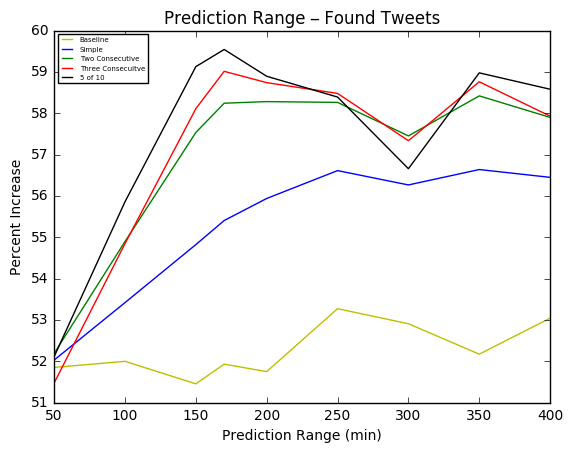

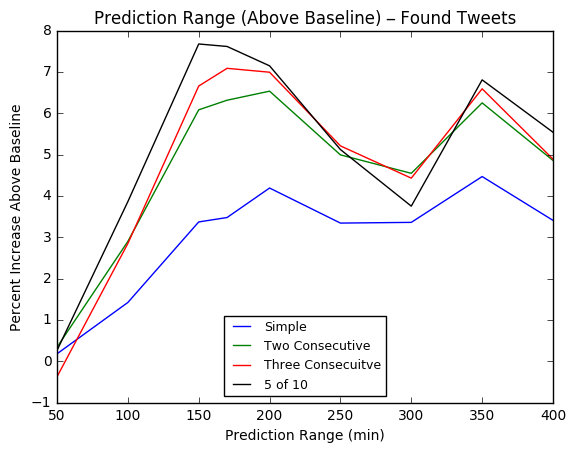

retweet: 1
[13760, 2902, 1251, 638]


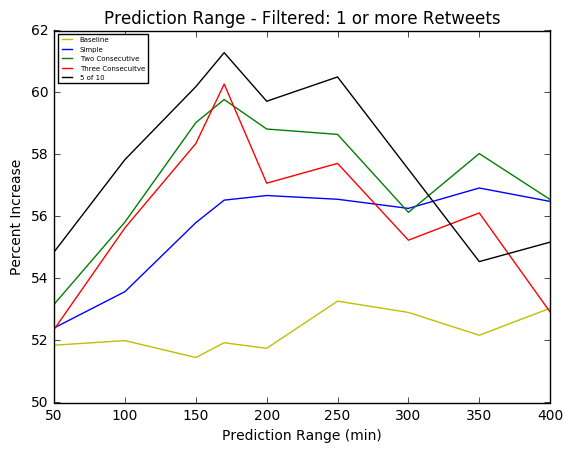

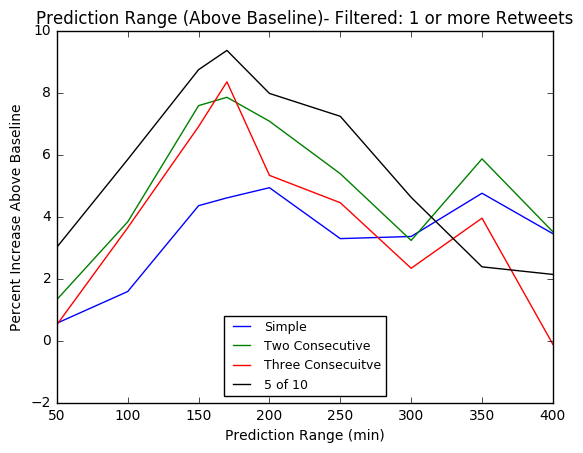

retweet: 2
[8435, 1605, 694, 230]


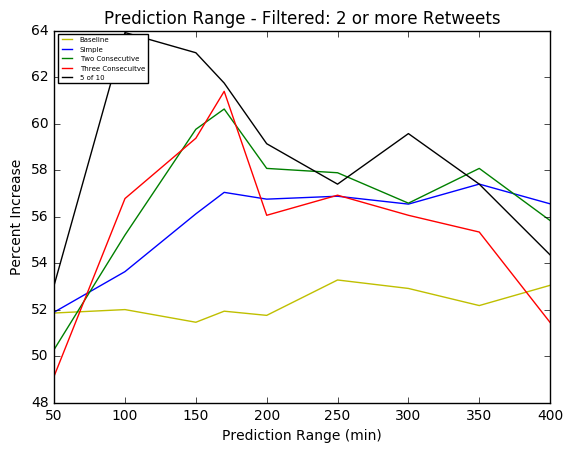

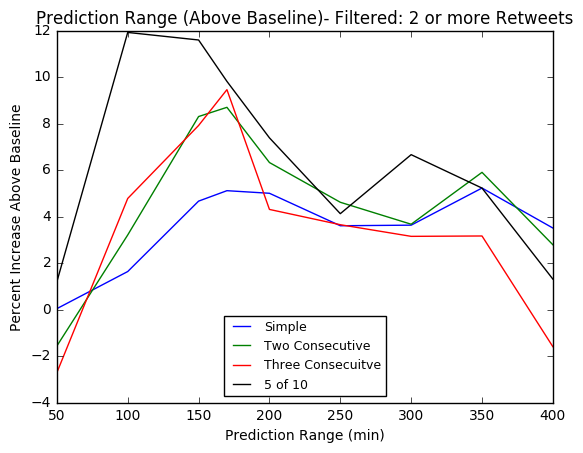

retweet: 3
[6123, 969, 383, 84]


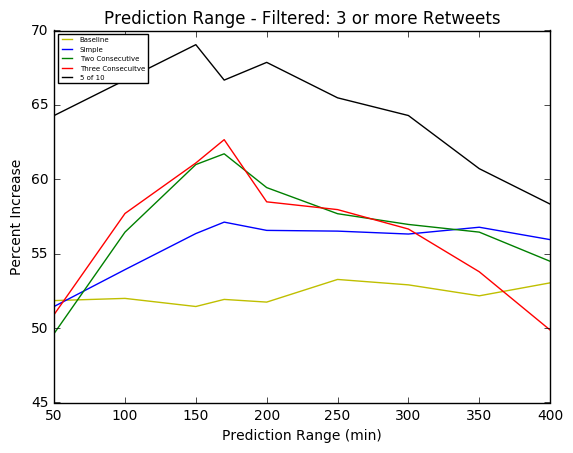

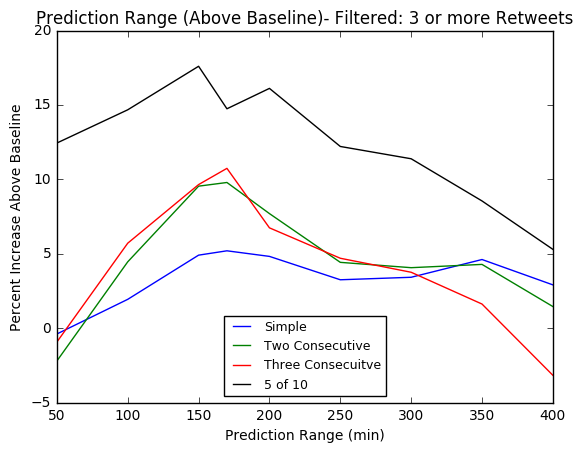

In [48]:
def analyze_upcount(method, tweets, price_window, count_min, retweet_min):
    dlist = [getDelta(df, d, price_window, 0) for d in tweets]
    dlist_count = Counter(dlist)   
    tweet_percentPos = dlist_count[2]/(len(dlist) - dlist_count[1])
    return tweet_percentPos

def tweet_stats(df, count_min, retweet_min):
    df2 = df[:-(800)]
    end_date = dt(2016, 11, 2, 0, 0, 0)
    tweets = list(collection.find({"_id": {"$lt": end_date}, "count": {"$gte": count_min},"retweets_total": {"$gte": retweet_min}}, { '_id':1}).sort([("_id", 1)]))
#     print(len(tweets))
    tweets = [x['_id'] for x in tweets]
    two_in_row =[]
    one_in_row = []
    high_count = []    
    recent = []
    for i, t in enumerate(tweets):
        if i > 1:
            near_count = near_count_loose = 0
            for r in recent: 
                if t-r < timedelta(minutes=10): near_count+=1
            minute = timedelta(minutes=1)
            if t - recent[-1] == minute and recent[-1] - recent[-2] == minute: two_in_row.append(t)
            if t - recent[-1] == minute == minute: one_in_row.append(t)
            if near_count>5:high_count.append(t)

        recent.append(t)
        if len(recent) > 10: recent.pop(0)
            
    boring_percent = []
    oir_percent = []
    xooy_percent =[]
    tir_percent = []
   
    price_windows = [50, 100, 150, 170, 200, 250, 300, 350, 400]
    for price_window in price_windows:
        boring = analyze_upcount("tweets", tweets, price_window, count_min, retweet_min)
        oir = analyze_upcount("one_in_row", one_in_row, price_window, count_min, retweet_min)
        tir = analyze_upcount("two_in_row", two_in_row, price_window, count_min, retweet_min)
        xooy = analyze_upcount("xooy", high_count, price_window, count_min, retweet_min)
#     analyze_upcount("high_count_loose", high_count_loose, price_window, count_min, retweet_min)
        boring_percent.append(boring)
        oir_percent.append(oir)
        tir_percent.append(tir)
        xooy_percent.append(xooy)
    return boring_percent, oir_percent, tir_percent, xooy_percent,  [len(tweets), len(one_in_row), len(two_in_row), len(high_count)]

def chart_baseline(p, boring, oir, tir, xooy, r):
    pw = [50, 100, 150, 170, 200, 250, 300, 350, 400]
#     p = [100 * x for  x in p]
    b = [100 * x for x in boring]
    o = [100 * x for x in oir]
    t = [100 *x for x in tir]
    x = [100 *x for x in xooy]

    plt.plot(pw, p, 'y', pw, b, 'b', pw, o, 'g', pw, t, 'r', pw, x, 'k')
    plt.ylabel('Percent Increase')
    plt.xlabel('Prediction Range (min)')
#     plt.axis([50, 400, 45, 65])
    plt.legend(['Baseline', 'Simple', "Two Consecutive", "Three Consecuitve", '5 of 10'], loc='upper left',prop={'size':5})
    if r != 0: plt.title('Prediction Range - Filtered: ' + str(r) + ' or more Retweets')
    else: plt.title('Prediction Range – Found Tweets')
    plt.show()

def chart_no_baseline(p, boring, oir, tir, xooy, r):
    pw = [50, 100, 150, 170, 200, 250, 300, 350, 400]
    b = [100 * x - p[i] for i, x in enumerate(boring)]
    o = [100 * x - p[i] for i, x in enumerate(oir)]
    t = [100 * x - p[i] for i, x in enumerate(tir)]
    x = [100 * x - p[i] for i, x in enumerate(xooy)]

    plt.plot(pw, b, 'b', pw, o, 'g', pw, t, 'r', pw, x, 'k')
    plt.ylabel('Percent Increase Above Baseline')
    plt.xlabel('Prediction Range (min)')
    if r != 0: plt.title('Prediction Range (Above Baseline)- Filtered: '+ str(r) + ' or more Retweets')
    else: plt.title('Prediction Range (Above Baseline) – Found Tweets')
        
    plt.legend(['Simple', "Two Consecutive", "Three Consecuitve", '5 of 10'], loc='lower center',prop={'size':9})
    plt.show()
    
    
def get_tweet_charts():
#     count_mins =  [0, 1, 2, 5]
    retweet_mins =  [0, 1, 2, 3]
#     for c in count_mins:
    for r in retweet_mins:
        print('retweet:', r)
#         print('count:', c, 'retweet:', r
        boring, oir, tir, xooy, lengths = tweet_stats(df, 0 ,r)
        print(lengths)
        chart_baseline(p, boring, oir, tir, xooy, r)
        chart_no_baseline(p, boring, oir, tir, xooy, r)

get_tweet_charts()

# boring, oir, tir, lengths = tweet_stats(df, 0 ,0)
# tweet_stats(df, 165, 0, 0)
# %lprun -f tweet_stats get_tweet_stats()

In [49]:
old_words = ['bitcoin', 'btc', 'blockchain', 'litecoin', 'usd',
'wallet', 'currency', 'altcoin', 'mining', 'gox', 'mt', 'crypto', 'new', 
'cryptocurrency', 'ethereum', 'fintech', 'ltc', 'free', 'digital', 'latest',
'money', 'bank', 'hardware', 'index', 'satoshi', 'market', 'economy', 'bitcoins',
'dogecoin', 'value', 'secure', 'miner', 'trading', 'coindesk', 'smart', 
'bitstamp', 'technology', 'euro', 'buy', 'trade', 
'coinbase', 'power', 'time', 'tech', 'trezor', 'bitfinex', 'algorithm', 'china', 'banks', 
'earn', 'past', 'landbitcoin', 'portal', 'win',
 'data', 'coin', 'best', 'cash', 'bitcoinnews', 'increased', 'cloud', 'average', 
'future', 'change', 'financial', 'virtual', 'startup', 'open', 'ceo', 'platform', 
'decreased', 'business', 'finance', 'convert', 'high', 'dash', 'altcoins', 'currencies', 
'collapse', 'libertarian', 'bot', 'dollar', 'movement', 'directly', 'game',
'global', 'technical', 'investment', 'launches', 'volume', 'network', 'support',
'observer', 'lost', 'security', 'secure', 'won', 'good', 'launch', 
'gambling', 'japan', 'invest', 'sell', 'wild', 'hack', 
'pay', 'exchanges', 'miners', 'crypto-currencies', 'forum', 'fast', 'sell', 'ledger', 
'mobile', 'grow', 'hot', 'great', 'wild', 'hack', 'miracle', 'bullish', 'solution', 'millionare']



# words_i_like  = ['bitcoin', 'btc', 'blockchain', 'litecoin', 'usd',
# 'wallet', 'currency', 'altcoin', 'mining', 'gox', 'mt', 'crypto', 'new', 
# 'cryptocurrency', 'ethereum', 'fintech', 'ltc', 'free', 'coindesk', 'pay']

words_i_like = ['cryptocoinsnews', 'currencies', 'tonight', 'antminer', 'join', 'block', 'chain', 'smart', 'real', 'prices', 'app', 'week', 'win', 'cloud', 'past', 'value']

for i, w in enumerate(words_i_like):
    print(i+4, w)


4 cryptocoinsnews
5 currencies
6 tonight
7 antminer
8 join
9 block
10 chain
11 smart
12 real
13 prices
14 app
15 week
16 win
17 cloud
18 past
19 value


In [60]:
from collections import defaultdict

from numpy import linalg as LA
import math

def scrape_window(start_date, end_date):
    twitter_start_date = start_date + timedelta(days=1)
    tweets = list(collection.find({"_id": {"$gt": twitter_start_date, "$lt": end_date}}).sort([("_id", 1)]))
    print(len(tweets))
    return tweets

def wordVector(tweet_text, retweets, list_size):
    words_list = old_words if list_size ==  'long' else words_i_like
    words = [w.lstrip('#') for w in tweet_text.lower().split(' ')]
    counts = Counter(words)
    fv = np.zeros(len(words_list))
    for i, word in enumerate(words_list): fv[i] = counts[word]
#     fv *= (retweets + 1)
    return fv

def sentimentTweet(tweet_text):
    b = TextBlob(tweet_text)
    fv = np.array([b.sentiment.polarity]) #[b.sentiment.subjectivity, 
    #
    return fv

def monthRange(start_date, end_date):
    week = timedelta(weeks=1)
    for n in range(int ((end_date - start_date).total_seconds()/(60*60*24*7)))[::4]:
        yield start_date + timedelta(weeks=n)
def normalize(vector):
    if np.count_nonzero(vector) == 0: return vector
    return vector/LA.norm(vector)

def weighted_average(date, most_recent, theta):
    av_month = np.zeros(len(most_recent[0][1]))
    for x in most_recent: 
        delta = (date - x[0]).total_seconds()/60
#         print(math.exp(-theta*delta))
#         print(x[1])
        av_month += x[1] * math.exp(-theta*delta)
    return av_month #/len(most_recent)

print(sentimentTweet("I hate this"))

[-0.8]


In [160]:
def buildfvs(start_date, last_date, tweet_window, price_window, theta, rt, mt):
    fvs = []
    targetdata =[]
    most_recent = []
#     ups = []
#     downs = []
    counter = 0
    total_tweets = 0
    cutoff = 0
#     retweets_min = 1
    for month in monthRange(start_date, last_date):
        monthFV = []
        monthTarget = []
        for tweet_min in scrape_window(month, month + timedelta(weeks=4)):
            count = tweet_min['count']
            date = tweet_min['_id']
            if count  < mt: continue
            counts = np.array([count, tweet_min['retweets_total']])
            w_short = np.zeros(len(words_i_like))
            w_long = np.zeros(len(old_words))
            sent = np.zeros(1)
            #add run length
            for tweet_text, retweets in zip(tweet_min['text'], tweet_min['retweets']):
                if retweets < rt: continue
                total_tweets+=1
                sent += sentimentTweet(tweet_text)
                w_short += wordVector(tweet_text, retweets, 'short')
            # ADD TO QUEUE
            mFV = np.concatenate((sent, normalize(counts))) 
#             mFV = np.concatenate((normalize(sent), normalize(counts), normalize(w_short))) 
#             mFV = normalize(w_short)
            otherFVs = [normalize(sent), normalize(w_short)] #normalize(counts),
            most_recent.append((date, mFV, otherFVs))
            ## REMOVE OLD FROM QUEUE
            while date -  most_recent[0][0] > timedelta(minutes=tweet_window): most_recent.pop(0) 
            ## ADD TO MONTH                
            counter += 1
            if counter > tweet_window:
                delta = getDelta(df, np.datetime64(date), price_window, cutoff)
                monthTarget.append(delta)
#                 av_month = np.average([x[1] for x in most_recent], axis=0)
                av_month = weighted_average(date, most_recent, theta)
                monthFV.append(av_month)
#                 if delta > 1: ups.append(av_month)
#                 if delta < 1: downs.append(av_month)
        fvs.append(monthFV)
        targetdata.append(monthTarget)
    print('total tweets:', total_tweets)
    return (fvs, targetdata) #, ups, downs)


In [129]:
# start_date = dt(2014, 1, 1, 0, 0, 0)
last_date = dt(2016, 11, 2, 0, 0, 0) # - timedelta(days=1)

fvs, targetdata, ups, downs = buildfvs(start_date, last_date, 200, 200, .002)
print(len(fvs))
print(len(targetdata))

# %lprun -f buildfvs buildfvs(start_date, last_date)
# %lprun -f getDelta getDelta(df, np.datetime64(date), price_window, cutoff)

TypeError: buildfvs() missing 2 required positional arguments: 'rt' and 'mt'

In [130]:
def runModel(modeltype, fva, tda, fvb, tdb):
    guessedup = 0
    model = modeltype[1]
    clf = model.fit(fva, tda)
    pred = clf.predict(fvb)

    count = total = 0
    for i, x in enumerate(pred):
        if x != 1 and tdb[i] != 1:
            count += 1
            if x == 2: guessedup+=1
            if x == tdb[i]: total += 1
    if count == 0: 
        print("count == 0")
        count = 1
    return (total/count, pred.mean()/2) #[modeltype[0], pred.mean()/2,  total/count, (len(pred) - count)/len(pred)]            


In [162]:
def split_list(a_list):
    third = int(len(a_list)/3)
    return a_list[:third], a_list[third:2*third], a_list[2*third:],

fvs_new = [item for sublist in fvs for item in sublist]
targetdata_new = [item for sublist in targetdata for item in sublist]
fva, fvb, fvc = split_list(fvs_new)
tda, tdb, tdc= split_list(targetdata_new)

target_up = [(sum(tda)/len(tdb))/2, (sum(tdb)/len(tdb))/2, (sum(tdc)/len(tdb))/2]
large_target_up = (sum(targetdata_new)/len(targetdata_new))/2

# print(len(fva))
# print(len(fva[0]))
# for fv in fva[0:20]: print(fv)
# print(tda[:300])

In [163]:
def generateCharts(rt):
    modeltypes = [('Logistic Regression', LogisticRegression()),
           ('MultinomialNB', GaussianNB()),
           ("RandomForestClassifier", RandomForestClassifier(n_estimators=500))]

    theta_res= []
    theta_list = [0, .0005, .001, .002,.005,.01, .5]
    
    for theta in theta_list:
        print(theta)
        fvs, targetdata = buildfvs(start_date, last_date, 200, 200, theta, rt, 0) #, ups, downs 
        fvs_new = [item for sublist in fvs for item in sublist]
        targetdata_new = [item for sublist in targetdata for item in sublist]
        fva, fvb, fvc = split_list(fvs_new)
        tda, tdb, tdc= split_list(targetdata_new)
        target_up = (sum(targetdata_new)/len(targetdata_new))/2
        r_mod = []
        for model in modeltypes:
            r_mod.append(runModel(model, fva, tda, fvb, tdb))
        theta_res.append(r_mod)
    return theta_list, theta_res, target_up

In [155]:
modeltypes = [('Logistic Regression', LogisticRegression()),
       ('MultinomialNB', GaussianNB()),
       ("RandomForestClassifier", RandomForestClassifier(n_estimators=500))]

fvs, targetdata = buildfvs(start_date, last_date, 200, 200, 0, 1, 0) #, ups, downs 
fvs_new = [item for sublist in fvs for item in sublist]
targetdata_new = [item for sublist in targetdata for item in sublist]
fva, fvb, fvc = split_list(fvs_new)
tda, tdb, tdc= split_list(targetdata_new)
target_up = (sum(targetdata_new)/len(targetdata_new))/2
r_mod = []
for model in modeltypes:
    print(runModel(model, fva, tda, fvb, tdb))

3187
3176
3356


KeyboardInterrupt: 

In [164]:
def graph_charts(theta_list, theta_res, target_up, rt):
    st = ""
    models = {'Logistic Regression':0, 'Gaussian Naive Bayes':0, "RandomForestClassifier":0}
    lr = []
    g = []
    rft = []
    if rt > 0: st = " (More than " + str(rt) + " retweets)" 

    for theta in theta_res:
        lr.append(theta[0][0])
        g.append(theta[1][0])
        rft.append(theta[2][0])
    tweet_baseline = [target_up] * len(theta_list)
    plt.plot(theta_list, lr, 'b', theta_list, g, 'g', theta_list, rft,'r', theta_list, tweet_baseline, 'k')
    plt.ylabel('Percent Accuracy')
    plt.xlabel('Theta')
    plt.xlim(0, .1)
    plt.title('Predictive Ability Based On Theta' + st)
    plt.legend(['Logistic Regression', 'Gaussian Naive Bayes', "Random Forest", "Baseline - Minutes w. Tweets"], loc='lower left',prop={'size':9})
    plt.show()
# graph_charts(theta_list, theta_res) 

0
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.0005
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.001
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.002
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.005
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.01
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101
0.5
3187
3176
3356
3425
3431
3701
3430
3407
3407
3787
3875
total tweets: 15101


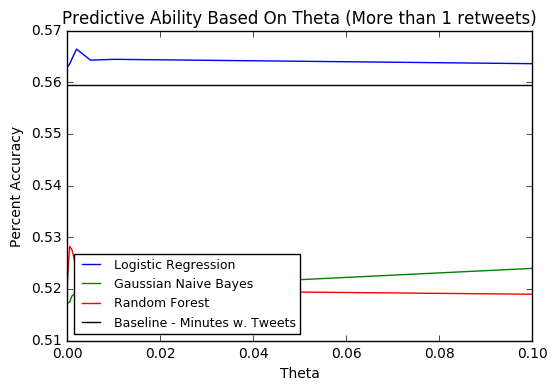

In [165]:
stored = {}
for rt in [1]:
    theta_list, theta_res, target_up  = generateCharts(rt)
    stored[rt] = (theta_list, theta_res, target_up)
    graph_charts(theta_list, theta_res, target_up, rt)

{1: ([0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.5], [[(0.562919661900624, 0.79699842022116907), (0.5171814519314322, 0.50102685624012633), (0.5205782447270717, 0.59589257503949444)], [(0.5634726281696817, 0.7977093206951027), (0.517418437475314, 0.50142180094786726), (0.5282407773125839, 0.6052922590837283)], [(0.5644995655265029, 0.79889415481832549), (0.5186033651947232, 0.50102685624012633), (0.5276088158622324, 0.60663507109004744)], [(0.5663954498775575, 0.80205371248025281), (0.5193933170076626, 0.50134281200631914), (0.5240164322957813, 0.61718009478672986)], [(0.5642625799826211, 0.82361769352290681), (0.5212102061774232, 0.50331753554502368), (0.5151275772177897, 0.59960505529225905)], [(0.564420570345209, 0.86216429699842023), (0.520025278458014, 0.508609794628752), (0.5197092977328382, 0.59225908372827807)], [(0.5598388498301604, 0.97022116903633493), (0.5414329725886721, 0.76366508688783574), (0.5156015483055534, 0.59770932069510263)]], 0.5593702280027382)}


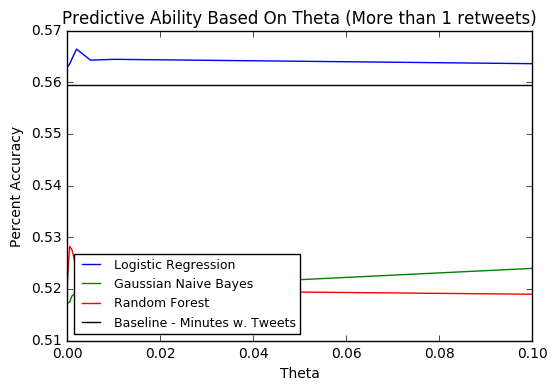

In [166]:
print(stored)
for rt in [1]:
    theta_list, theta_res, target_up = stored[rt]
    graph_charts(theta_list, theta_res, target_up, rt)

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
modeltypes = [('Logistic Regression', LogisticRegression()),
           ('MultinomialNB', GaussianNB()),
           ("RandomForestClassifier", RandomForestClassifier(n_estimators=500))]

print('======== Tuning ========')
print('start date: ', start_date)
print('price window =  minutes after tweet: ', price_window) # '. minutes before:', MINUTES_BEFORE)
print('tweet window = number of tweets looked at: ', tweet_window)
print('minimum tweets in minute: ', min_tweets)
print('minimum retweets: ', retweets_min)
print('cutoff:', cutoff)
print('tweet_accuracy', large_target_up)
print('========================')

# print("percent of bitcoin increases over time", nonTweet_percentPos)
print("percentage of target up:", target_up)

for model in modeltypes:
    c = runModel(model, fva, tda, fvb, tdb)
    print('\n')
    print(c[0])
    print("percentage of predictions up:", c[1])
    print('percent_accurate:', c[2])
    print('(amount removed:', str(c[3]) + '%)')

======== Tuning ========
start date:  2016-01-01 00:00:00
price window =  minutes after tweet:  200
tweet window = number of tweets looked at:  200
minimum tweets in minute:  1
minimum retweets:  1
cutoff: 0.25
tweet_accuracy 0.5593702280027382
percentage of target up: [0.5601895734597157, 0.5632306477093207, 0.5547788309636651]




IndexError: invalid index to scalar variable.

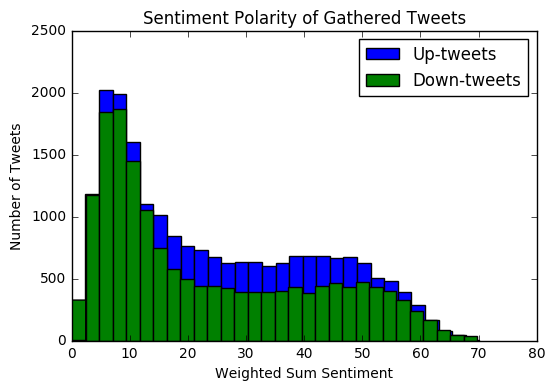

In [149]:
%matplotlib inline

import matplotlib.pyplot as plt
idx = 1
up = plt.hist([a[idx] for a in ups], bins=30, color='b')
down = plt.hist([a[idx] for a in downs], bins=30, color='g')
plt.title('Sentiment Polarity of Gathered Tweets')
plt.legend(['Up-tweets', 'Down-tweets'])
plt.xlabel('Weighted Sum Sentiment')
plt.ylabel('Number of Tweets')

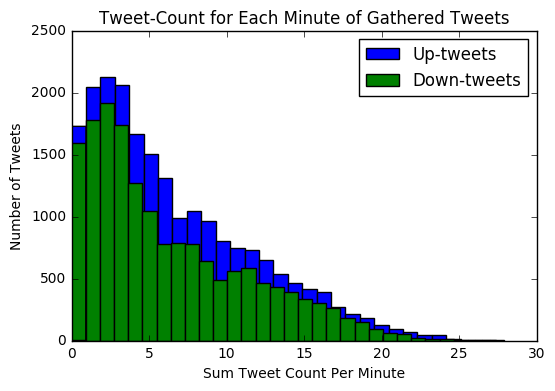

In [18]:
idx = 2
up = plt.hist([a[idx] for a in ups], bins=30)
down = plt.hist([a[idx] for a in downs], bins=30)
plt.title('Tweet-Count for Each Minute of Gathered Tweets')
plt.legend(['Up-tweets', 'Down-tweets'])
plt.xlabel('Sum Tweet Count Per Minute')
plt.ylabel('Number of Tweets')

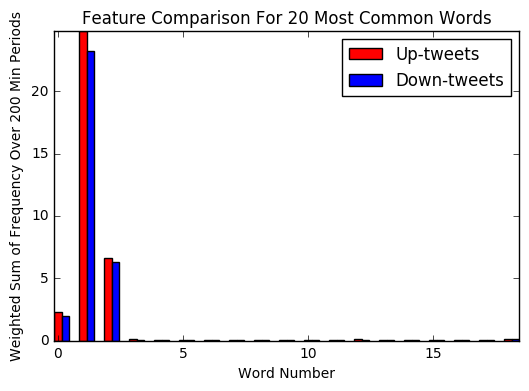

In [19]:
import numpy as np
%matplotlib inline
av_up = np.average(ups, axis=0)
av_down = np.average(downs, axis=0)
var_up = np.std(ups, axis=0)
var_down = np.std(downs, axis=0)

w = 0.3
x = range(len(av_up))
xw = [a + .3 for a in x]

up = plt.subplot(111)
up.bar(x, av_up, width=w,color='r',align='center')
up.bar(xw , av_down, width=w,color='b',align='center')
up.autoscale(tight=True)
plt.legend(['Up-tweets', 'Down-tweets'])
plt.xlabel('Word Number')
plt.ylabel('Weighted Sum of Frequency Over 200 Min Periods')
plt.title('Feature Comparison For 20 Most Common Words')
plt.figure(figsize=(1,1))
plt.show()

# plt.bar(range(len(ups)),downs)
# plt.show()

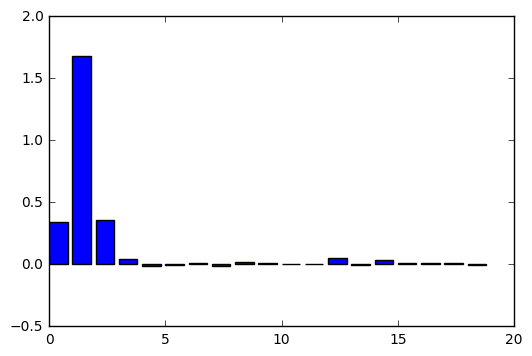

In [20]:
differences = av_up - av_down
plt.bar(range(len(av_up)),differences)
plt.show()


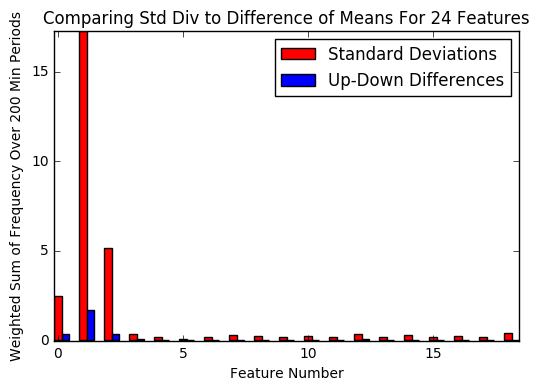

In [21]:
w = 0.3
x = range(len(av_up))
xw = [a + .3 for a in x]

up = plt.subplot(111)
up.bar(x, var_up, width=w,color='r',align='center')
up.bar(xw , differences, width=w,color='b',align='center')
up.autoscale(tight=True)
plt.legend(['Standard Deviations', 'Up-Down Differences'])
plt.xlabel('Feature Number')
plt.ylabel('Weighted Sum of Frequency Over 200 Min Periods')
plt.title('Comparing Std Div to Difference of Means For 24 Features')
plt.show()






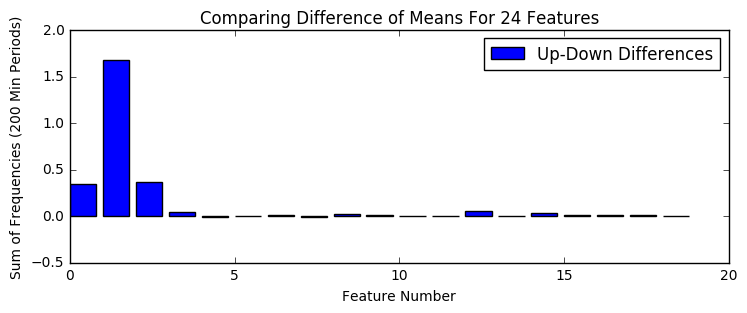

In [22]:
# up.bar(x, var_up, width=w,color='r',align='center')
plt.rcParams["figure.figsize"] = [8.5, 3]
plt.bar(x, differences, color='b')
plt.legend(['Up-Down Differences'])
plt.xlabel('Feature Number')
plt.ylabel('Sum of Frequencies (200 Min Periods)')
plt.title('Comparing Difference of Means For 24 Features')
# Set figure width to 12 and height to 9
plt.figure(figsize=(1,1))
plt.rcParams["figure.figsize"] = [6.4, 4.8]

In [23]:
def joinList(alist):
    return [item for sublist in alist for item in sublist]

def cont_learning(number_months, fvs, targetdata):
    modeltypes = [('Logistic Regression', LogisticRegression()),
           ('MultinomialNB', MultinomialNB()),
           ("RandomForestClassifier", RandomForestClassifier())]
    
    percents_accurate ={'Logistic Regression':[],'MultinomialNB':[], "RandomForestClassifier":[]}
    percents_upGuess ={'Logistic Regression':[],'MultinomialNB':[], "RandomForestClassifier":[]}

    for i in range(len(fvs)-number_months):
        fva = joinList(fvs[i:i + number_months])
        tda = joinList(targetdata[i:i + number_months])
        fvb = joinList(fvs[i + number_months :i + 2 * number_months])
        tdb = joinList(targetdata[i + number_months:i + 2 * number_months])
        if i == 0: print("first tweet baseline", sum(tdb)/len(tdb)/2)
        assert(len(fva) == len(tda))
        assert(len(fvb) == len(tdb))
        
        for model in modeltypes:
            c = runModel(model, fva, tda, fvb, tdb)
#             print('\n')
#             print(len(fva))
#             print(c[0])
#             print("percentage of predictions up:", c[1])
#             print('percent_accurate:', c[2])
#             print('(amount removed:', str(c[3]) + '%)')
            percents_accurate[model[0]].append(c[2])
            percents_upGuess[model[0]].append(c[1])
    return percents_accurate, percents_upGuess

for pw in [100, 200, 300, 400, 500]:
    nonTweet_percentPos = change_stats(df, pw)
    for tw in [10, 50, 100, 200, 300]:
        fvs, targetdata, a, b = buildfvs(start_date, last_date, tw, pw)
        td_total = joinList(targetdata)
        print('======= NEW FV: tw:', tw, 'pw:', pw, '============')
        print("tweet score", sum(td_total)/len(td_total)/2)

        for i in [3, 4, 5, 6, 7]:
            print('i:', i)
            percents_accurate, percents_upGuess = cont_learning(i, fvs, targetdata)
            for model in [x[0] for x in modeltypes]:
                indicator = ''
                res = percents_accurate[model]
                upguess = percents_upGuess[model]
                acc_mean = sum(res)/len(res)
                upguess_mean = sum(upguess)/len(upguess)
                if upguess_mean < .86 and acc_mean > .55: indicator = "*******"
                if acc_mean > .6: indicator = "*******"
                print(model, acc_mean, 'upguess:', upguess_mean, indicator)
            print('---------------')
            

2016-01-01 00:00:00
3187
2016-01-29 00:00:00
3176
2016-02-26 00:00:00
3356
2016-03-25 00:00:00
3425
2016-04-22 00:00:00
3431
2016-05-20 00:00:00
3701
2016-06-17 00:00:00
3430
2016-07-15 00:00:00
3407
2016-08-12 00:00:00
3407
2016-09-09 00:00:00
3787
2016-10-07 00:00:00
3875
======= NEW FV: tw: 10 pw: 100 ============
tweet score 0.5344755318034161
i: 3


NameError: name 'MultinomialNB' is not defined